## Questions to answer:

1) What is the average mitochondria area?

2) What is the average mitochondria volume?

3) Are the cells spherical, elliptical, some other odd shape?

4) How much variation is there in contrast?

5) Are there significant differences in average intensity in the two regions?

# DON'T FORGET TO ADD TITLES AND LABELS TO GRAPHS

In [7]:
#Import necessary packages and set plot types to allow interactive plots
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
%matplotlib notebook

In [2]:
#Load numpy arrays from last notebook
training_inputs = np.load('training_inputs.npy')
training_ground_truth = np.load('training_ground_truth.npy')

In [3]:
#A useful function I adapted from CS231n code
def visualize_grid(image_stack, upper_bound = 255.0, padding = 1):
    """
    Reshape a stack of images into a grid for easy visualization.
    
    Inputs:
    - image_stack: Data in shape (N, C, W, H)
    - upper_bound: pixel intensity will be scaled to the range [0, upper_bound]
    - padding: Number of blank pixels between elements of grid
    """
    
    N, C, W, H = image_stack.shape
    image_stack = image_stack.transpose(0,3,2,1)
    grid_size = int(np.ceil(np.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_img = 0
    y0, y1 = 0, H
    for row in range(grid_size):
        x0, x1 = 0, W
        for col in range(grid_size):
            if next_img < N:
                img = image_stack[next_img]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = upper_bound * (img - low)/(high - low)
                next_img += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
        
    return grid

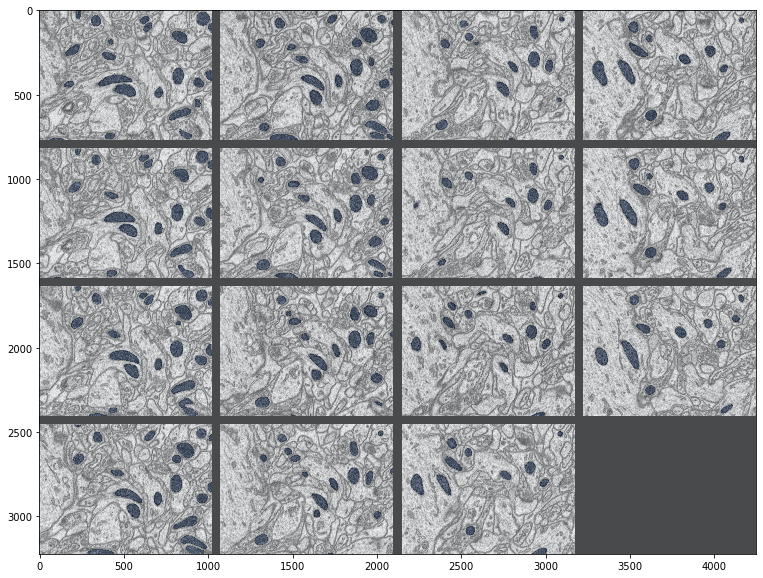

In [4]:
#Overlay images to highlight mitochondria, there may be a better way to do this since the black tiles also get overlaid
grid_image = visualize_grid(training_inputs[::11],padding = 50)
grid_overlay = visualize_grid(training_ground_truth[::11],padding = 50)
plt.imshow(grid_image[:,:,0].T.astype('uint8'), cmap = 'gray')
plt.imshow(grid_overlay[:,:,0].T.astype('uint8'), cmap = 'Blues',alpha = 0.3)
plt.gcf().set_size_inches(15,10)
plt.show()

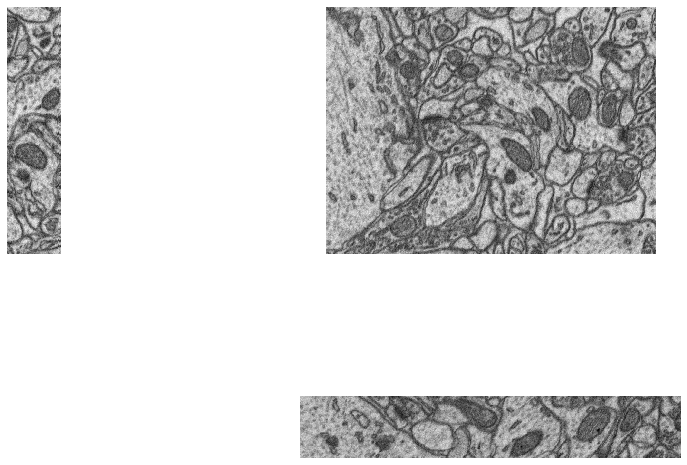

In [5]:
#Plot the three different views of the data prism
plt.subplot(2,2,1)
plt.imshow(training_inputs[:,0,:,600].T,cmap='gray')
plt.gca().axis('off')
plt.subplot(2,2,4)
plt.imshow(training_inputs[:,0,300,:],cmap='gray')
plt.gca().axis('off')
plt.subplot(2,2,2)
plt.imshow(training_inputs[80,0,:,:],cmap='gray')
plt.gca().axis('off')
plt.gcf().set_size_inches(15,10)
plt.show()

<IPython.core.display.Javascript object>


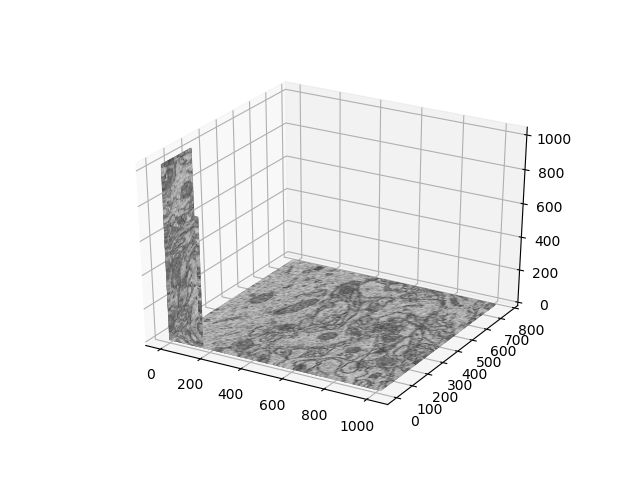

(768, 1024) (768, 1024) (768, 1024) (768, 1024, 165)


In [56]:
#Cool visual, but needs a little work, would like the aspect ratios to be consistent, and get the pictures to line up
image_stack = training_inputs[:,0,:,:]
image_stack = image_stack.transpose(1,2,0)
W,H,N = image_stack.shape

xx, yy = np.meshgrid(np.linspace(0,H-1,H),np.linspace(0,W-1,W))
yyy, zzz = np.meshgrid(np.linspace(0,N-1,N),np.linspace(0,H-1,H))
xxxx, zzzz = np.meshgrid(np.linspace(0,N-1,N),np.linspace(0,W-1,W))



data_top = image_stack[:,:,0]/255
data_bottom = image_stack[:,:,-1]/255
data_left = image_stack[:,0,:]/255
data_right = image_stack[:,-1,:]/255
data_front = image_stack[0,:,:]/255
data_back = image_stack[-1,:,:]/255
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
print(data_top.shape,xx.shape,yy.shape,image_stack.shape)

ax.plot_surface(xx,yy,np.ones(data_top.shape),rstride=8,cstride=8,facecolors = plt.cm.gray(data_bottom),shade = False)
ax.plot_surface(xx,yy,np.zeros(data_bottom.shape),rstride=8,cstride=8,facecolors = plt.cm.gray(data_top),shade=False)

ax.plot_surface(np.ones(yyy.shape),yyy,zzz,rstride=8,cstride=8,facecolors = plt.cm.gray(data_back),shade = False)
ax.plot_surface(np.zeros(yyy.shape),yyy,zzz,rstride=8,cstride=8,facecolors = plt.cm.gray(data_front),shade=False)

ax.plot_surface(xxxx,np.ones(xxxx.shape),zzzz,rstride=8,cstride=8,facecolors = plt.cm.gray(data_left),shade = False)
ax.plot_surface(xxxx,np.zeros(xxxx.shape),zzzz,rstride=8,cstride=8,facecolors = plt.cm.gray(data_right),shade=False)
plt.show()

In [38]:
for i in np.linspace(0,3,4):
    print(i)

0.0
1.0
2.0
3.0


In [9]:
#Not the smartest algorithm in the world, but it gets the job done
def Count_Convex_Shapes(image_mask):
    padded_image_mask = np.pad(image_mask,pad_width = ((1,),(1,)), mode = 'constant')
    I,J = padded_image_mask.shape
    last_pos_edges = 0
    row_shapes = 0
    col_shapes = 0
    for i in range(I):
        edge_raster = padded_image_mask[i,1:] - padded_image_mask[i,:-1]
        current_pos_edges = (edge_raster > 0).sum()
        if current_pos_edges > last_pos_edges:
            row_shapes += current_pos_edges - last_pos_edges
        last_pos_edges = current_pos_edges
    
    for j in range(J):
        edge_raster = padded_image_mask[1:,j] - padded_image_mask[:-1,j]
        current_pos_edges = (edge_raster > 0).sum()
        if current_pos_edges > last_pos_edges:
            col_shapes += current_pos_edges - last_pos_edges
        last_pos_edges = current_pos_edges
    return np.maximum(row_shapes, col_shapes)
            

In [10]:
#Find the average mitochondria size
N = training_ground_truth.shape[0]
avg_area = 0
for n in range(N):
    shapes = Count_Convex_Shapes(training_ground_truth[n,0,:,:])
    area = 25*(training_ground_truth[n,0,:,:]>0).sum() #normalize to 25 nm^2 per pixel
    if shapes > 0:
        avg_area += area/shapes
avg_area /= N
print('The average mitochondrial area is', round(avg_area,1), 'square nanometers\n')

The average mitochondrial area is 70013.9 square nanometers



In [11]:
#Find the average mitochondria volume
def Count_Convex_Blobs(image_cube):
    N = image_cube.shape[0]
    blobs = 0
    last_shapes = 0
    for n in range(N):
        current_shapes = Count_Convex_Shapes(image_cube[n,:,:])
        if current_shapes > last_shapes:
            blobs += current_shapes - last_shapes
        last_shapes = current_shapes
    return blobs

blobs = Count_Convex_Blobs(training_ground_truth[:,0,:,:])
volume = 125*(training_ground_truth[:,0,:,:]>0).sum()
print('The average mitochondrial volume is', round(volume/blobs,1),'cubic nanometers\n')

The average mitochondrial volume is 13430224.3 cubic nanometers



<IPython.core.display.Javascript object>


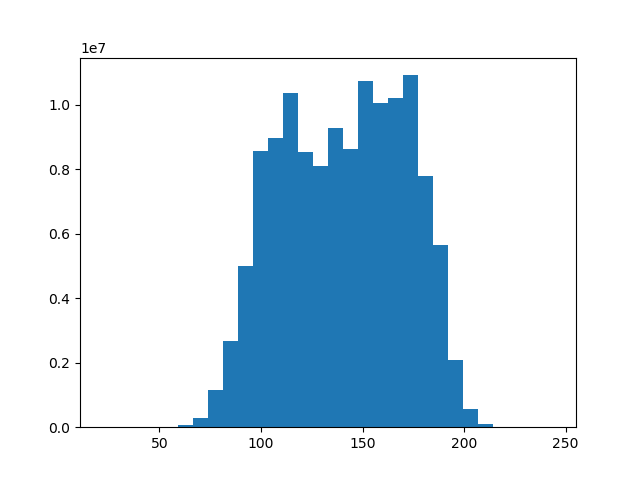

In [12]:
#Make a histogram of the input values
plt.hist(np.ravel(training_inputs), bins = 30)
plt.show()

In [13]:
#Create two separate sets, one of data points of mitochondria, one of non-mitochondria
image_mask = training_ground_truth > 0
mitochondria_image = image_mask*training_inputs
nonmitochondria_image = (1-image_mask)*training_inputs

<IPython.core.display.Javascript object>


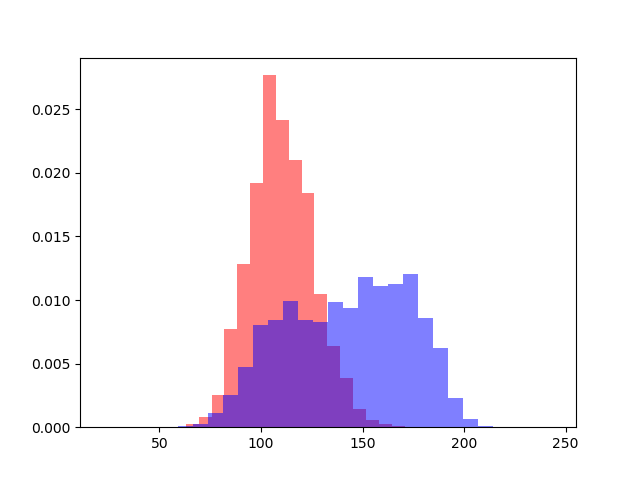

In [16]:
#Plot normalized histograms to see if we can just select darker regions and call them mitochondria
#Thresholding won't work, nice to know
plt.hist(np.ravel(mitochondria_image[np.nonzero(mitochondria_image)]), bins = 30,alpha = 0.5, color = 'red',density = True)
plt.hist(np.ravel(nonmitochondria_image[np.nonzero(nonmitochondria_image)]), bins = 30,alpha = 0.5, color = 'blue',density = True)
plt.show()

In [17]:
#Set up some data to get a 3D look at mitochondria
image_cube = training_ground_truth[:,0,:,:]
image_edges = image_cube[1:,1:,1:] - image_cube[:-1,1:,1:]
image_edges += image_cube[1:,1:,1:] - image_cube[1:,:-1,1:]
image_edges += image_cube[1:,1:,1:] - image_cube[1:,1:,:-1]
x, y, z = np.where(image_edges != 0)

<IPython.core.display.Javascript object>


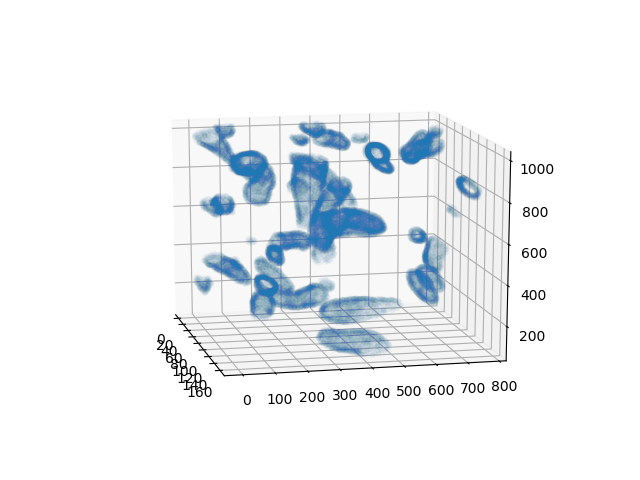

In [18]:
#Fix aspect ratio, makes mitochondria appear more enlongated than they are
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(x[::20],y[::20],z[::20],alpha = 0.01, linewidth = 0,marker='.')
plt.show()